# Gravitational Wave Detection

This is the final project done as part of the General Assembly's Data Science Immersive course in Jul/Aug 2021.

<img src="https://media.springernature.com/full/springer-static/image/art%3A10.1038%2Fs41586-019-1129-z/MediaObjects/41586_2019_1129_Fig1_HTML.png?as=webp" alt="drawing" width="700"/>

source: https://www.nature.com/articles/s41586-019-1129-z/figures/1

## Introduction

Gravitational Waves have been discussed since the beginning of the 20th century, and scientifically researched since the _Einstein's General Theory of Relativity_. They are caused by massive celestial bodies, like the Neutron Stars or Black Holes, when they accelerate they cause _gravitational waves_, in the form of waves, propagating through the curvature of space-time at the speed of light. These disturbances can be felt on the other side of the observable universe, but are extremely weak as they lose energy as gravitational radiation. It can be imagined similar to throwing a pebble in the pond, the site where the pebble hits water is the source of the disturbance and the outgoing ripples, are the gravitational waves, that get weaker as they move away from the source.

#### So now, why are they important?

The gravitational waves opens new "windows" to observe and study the events of universe, which were not possible only with the electromagnetic radiation that we usually rely on. These waves travel through the universe without interacting with matter and thus virtually undisturbed. Detecting them can unpack a lot of information about their origin and how our universe works.

#### Okay, how do we detect them?

They can be detected directly or indirectly. 

That's where Machine Learning comes in ...

[kaggle](https://www.kaggle.com/c/g2net-gravitational-wave-detection/)

### Problem Statement

_Build a modelling pipeline to read, preprocess, train and predict the gravitational wave data. Since it is really difficult to tell the samples with and without GW signals apart, use ROC AUC metric to build the best classifier._

---

### Executive Summary

Signal processing

**Content:**


In [5]:
# Import libraries
import numpy as np
import pandas as pd

# Plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Import the kaggle API to download data files as required
try:
    import kaggle
except:
    !pip install -q --user kaggle
    import kaggle

One of libraries for easy access and analysis of the Gravitational Waves directly in python is `GWpy`, as mentioned in [Gravitational Wave Open Science Center](https://www.gw-openscience.org/about/), which is an open source collaboration platform between the various observatories studying the gravitational science. Most of the functions used here are some mathematical operations that can be computed manually but we can use these libraries to ease the process.

In [6]:
# Gravitational wave analysis python library
try:
    import gwpy
except:
    !pip install -q --user gwpy
    import gwpy
from gwpy.timeseries import TimeSeries

In [7]:
# Training IDs
train = pd.read_csv('../data_source/training_labels.csv')

Because the entire dataset is very large, instead of downloading everything, we can write functions that would fetch the samples, and we can perform some analysis with those.

In [8]:
# function to donwload the file and unzip
def download_unzip(id_, file):
    !kaggle competitions download g2net-gravitational-wave-detection -f {file} -p ../data_source/ -q
    return f"../data_source/{id_}.npy"

In [9]:
# data source url -- get the npy files from kaggle API
def get_data(id_, is_train=True):
    if is_train:
        file = f'train/{id_[0]}/{id_[1]}/{id_[2]}/{id_}.npy'
    else:
        file = f'test/{id_[0]}/{id_[1]}/{id_[2]}/{id_}.npy'
        
    return np.load(download_unzip(id_, file))

In [10]:
# set of observatories
obs_list = ('LIGO Hanford', 'LIGO Livingston', 'Virgo')

#### Analyze train data

In [11]:
# check the shape of the training data
train.shape

(560000, 2)

In [12]:
# Target distribution in train data
train['target'].value_counts(normalize=True)

0    0.500125
1    0.499875
Name: target, dtype: float64

The entire train data contains 560000 observations, each having a file containg the respective strain data from the three observatories. The target variable, which is a binary value for the gravitational wave present, is uniformly distributed between the two classes.

In [13]:
# draw a random sample from the train data
sample_gw_id = train[train['target'] == 1].sample(random_state=42)['id'].values[0]

We know from context, that the `npy` files contain 3 arrays, one from each observatory $-$ LIGO Hanford, LIGO Livingston, and Virgo $-$ and denotes the strain values. Let's visualize these and have a look at a sample data file which contains the gravitational wave signal.

In [14]:
# Plot the sample data
def plot_sample_data(sample_id):
    # Get the data
    sample = get_data(sample_id)
    
    fig, ax = plt.subplots(3, 1, figsize=(12, 10), sharey=True)
    target = train[train['id'] == sample_id]['target'].values
    plt.suptitle(f"Strain data for three observatories from sample: {sample_id} | Target: {target[0]}")

    for i in range(3):
        sns.lineplot(data=sample[i], ax=ax[i], color=sns.color_palette()[i])
        ax[i].legend([obs_list[i]])
        ax[i].set_xlim(0, 4096)
        ax[i].set_xticks(ticks=[0, 2048, 4096]);
        ax[i].set_xticklabels(labels=[0, 1, 2]);

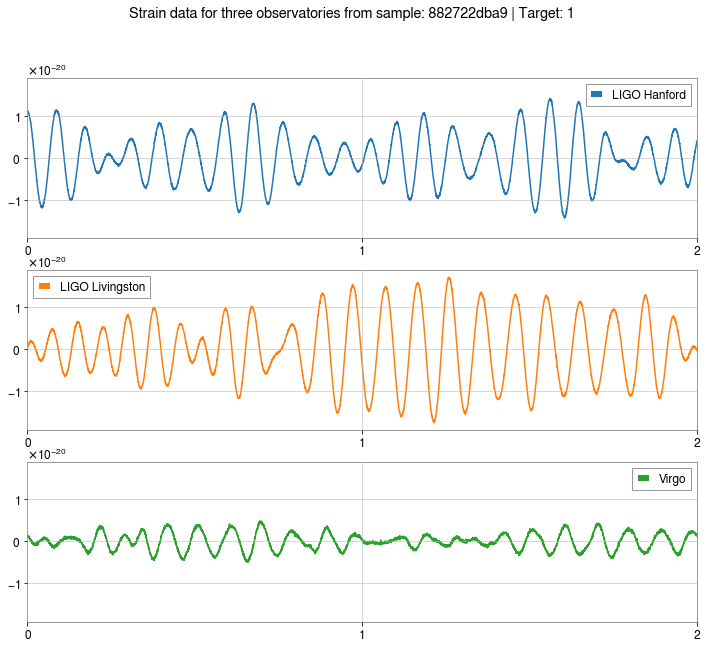

In [15]:
# plot the sample with gravitational wave signal
plot_sample_data(sample_gw_id)

The three plots above show the strain values sampled for 2s at 2048 Hz for id `882722dba9`. Out of the three readings, the two LIGO values are similar in amplitude while the Virgo is smaller. Even though this particular sample has gravitaional wave signal, it is burried deep in the instrument noise.

In [16]:
# draw another random sample from train without gravitational wave signal
sample_no_gw_id = train[train['target'] == 0].sample(random_state=42)['id'].values[0]

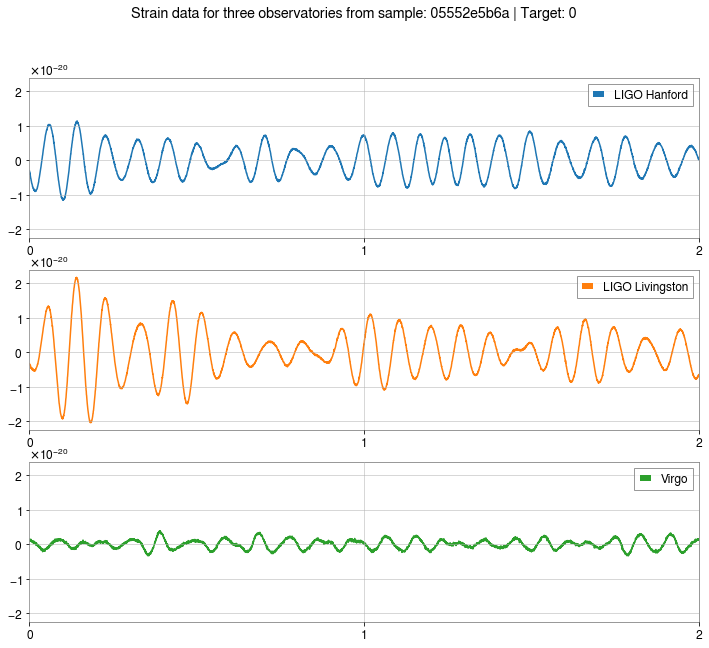

In [17]:
# plot the sample without gravitational wave signal
plot_sample_data(sample_no_gw_id)

Similarly, for the sample `05552e5b6a` without gravitational wave signal, we cannot visually see any signs. The strain is of the order $10^{-20}$, which is extremely small and can be affected by many external factors. However, as seen in both the sample plots, the strain data is a combination of many frequencies and analysing the signals in _frequency domain_, instead of the time domain, might give us better insights.

A _Fourier Transform_ is the most commonly used method in maths and signal processing, to decompose the signals into its constituent discrete frequencies. This spectrum of frequencies can be analyzed based on average, power or energy of the signal to get a spectral density plot. We will follow some of the concepts from this [tutorial](https://www.gw-openscience.org/LVT151012data/LOSC_Event_tutorial_LVT151012.html#Intro-to-signal-processing). As it says, one of the ways to visualize a raw signal in frequency domain is by plotting the amplitude spectral density (ASD).

In [18]:
# let's define some signal parameters
sample_rate = 2048 # data is provided at 2048 Hz
signal_length = 2 # each signal lasts 2 s
qrange = (16, 32)

In [19]:
# function to plot the amplitude spectral density (ASD) plot
def plot_asd(sample_id):
    # Get the data
    sample = get_data(sample_id)
    
    # we convert the data to gwpy's TimeSeries for analysis
    for i in range(sample.shape[0]):
        ts = TimeSeries(sample[i] / np.max(np.abs(sample[i])), sample_rate=sample_rate)
        ax = ts.asd(signal_length).plot(figsize=(12, 5)).gca()
        ax.set_xlim(10, 1024);
        ax.set_title(f"ASD plots for sample: {sample_id} from {obs_list[i]}");

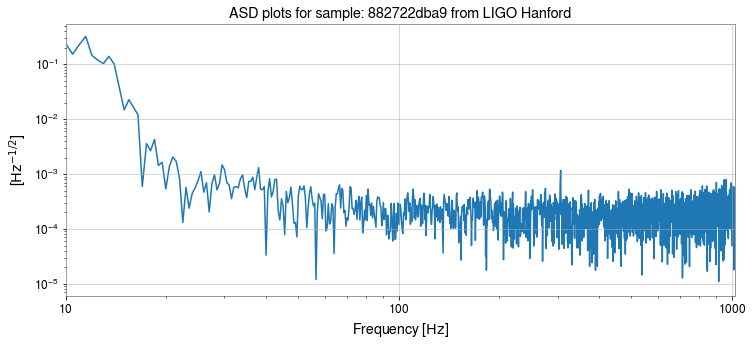

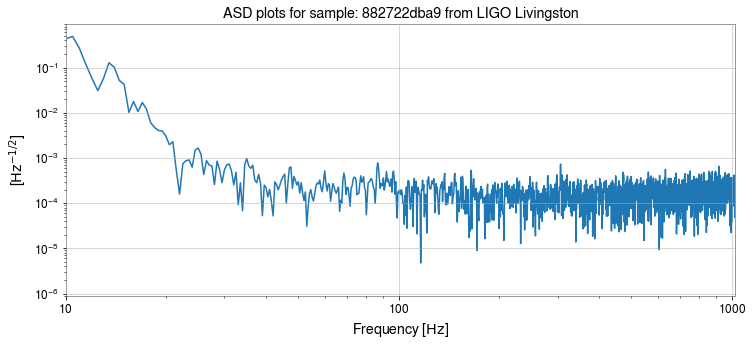

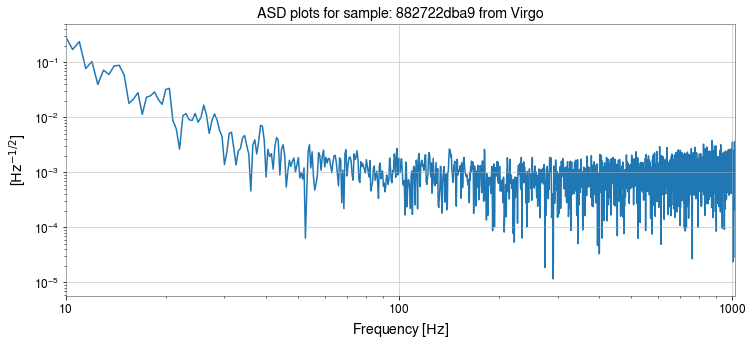

In [20]:
plot_asd(sample_gw_id)

In [18]:
sample_gw_ts = TimeSeries(get_data(sample_gw_id)[0], sample_rate=sample_rate)

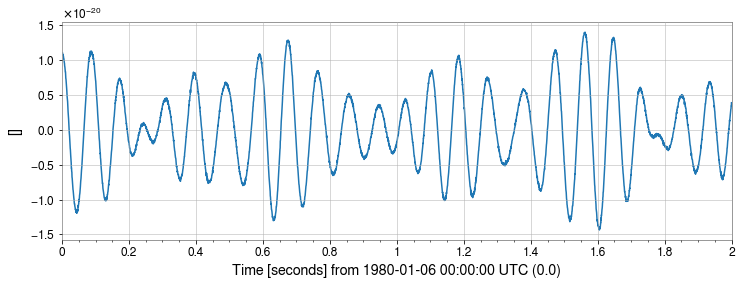

In [19]:
plot = sample_gw_ts.plot()
ax = plot.gca()
ax.set_xlim(0, 2);

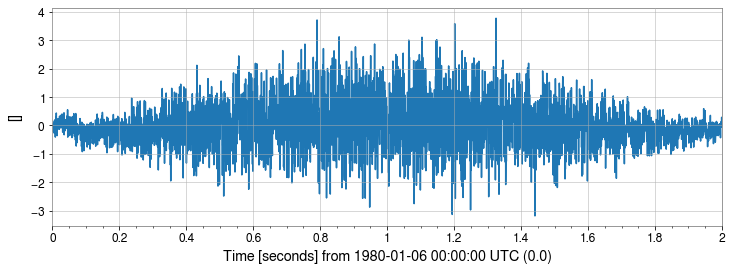

In [20]:
plot = sample_gw_ts.whiten(window=('hanning')).plot()
ax = plot.gca()
ax.set_xlim(0, 2);

In [21]:
2048/8

256.0

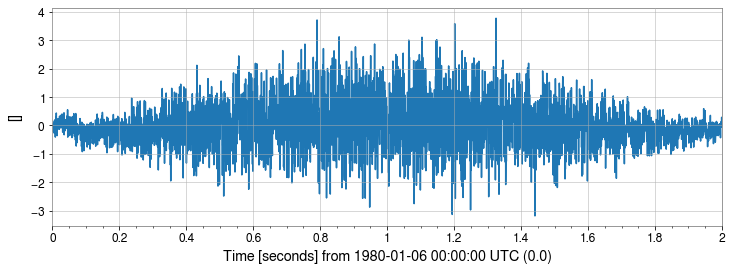

In [22]:
plot = sample_gw_ts.whiten().plot()
ax = plot.gca()
ax.set_xlim(0, 2);

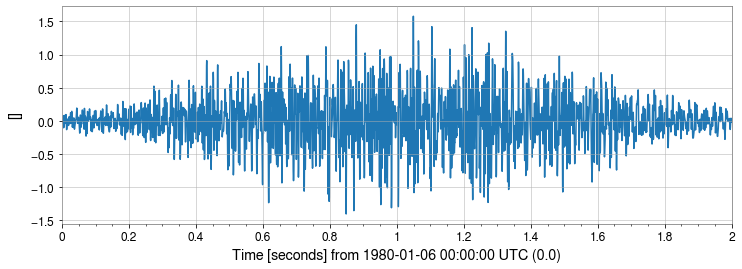

In [23]:
plot = sample_gw_ts.whiten().bandpass(35, 350).plot()
ax = plot.gca()
ax.set_xlim(0, 2);

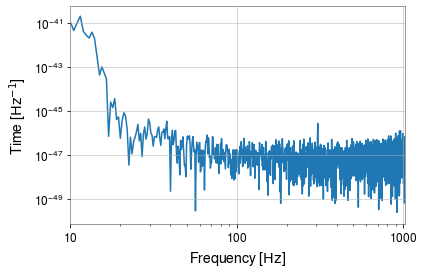

In [36]:
plot = sample_gw_ts.psd(signal_length).plot()
ax = plot.gca()
ax.set_xlim(10, 1024);

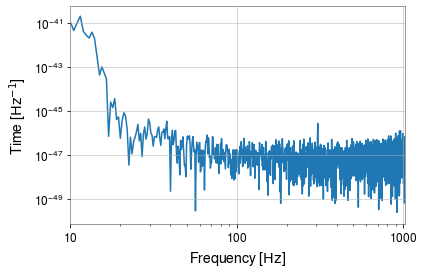

In [30]:
plot = sample_gw_ts.psd().plot()
ax = plot.gca()
ax.set_xlim(10, 1024);

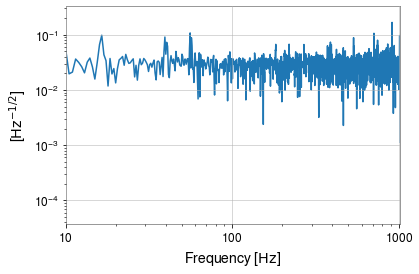

In [23]:
plot = sample_gw_ts.whiten().asd(signal_length).plot()
ax = plot.gca()
ax.set_xlim(10, 1024);

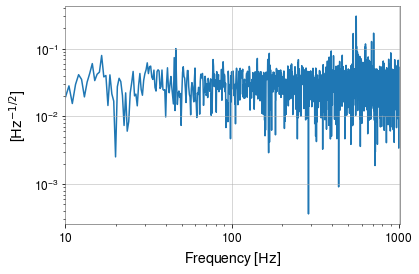

In [24]:
plot = sample_gw_ts.whiten(window=('tukey', 0.2)).asd(signal_length).plot()
ax = plot.gca()
ax.set_xlim(10, 1024);

In [25]:
sample_gw_ts.q_transform().shape

(1000, 931)

In [29]:
# function to plot the Q-transform spectrogram
def plot_q_transform(sample_id):
    # Get the data
    sample = get_data(sample_id)
    
    # we convert the data to gwpy's TimeSeries for analysis
    for i in range(sample.shape[0]):
        ts = TimeSeries(sample[i], sample_rate=sample_rate)
        ax = ts.q_transform(whiten=True).plot().gca()
        ax.set_xlabel('')
        ax.set_title(f"Spectrogram plots for sample: {sample_id} from {obs_list[i]}")
        ax.grid(False)
        ax.set_yscale('log');

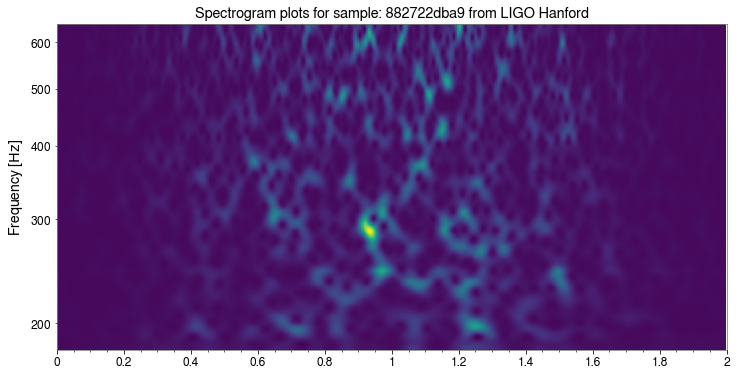

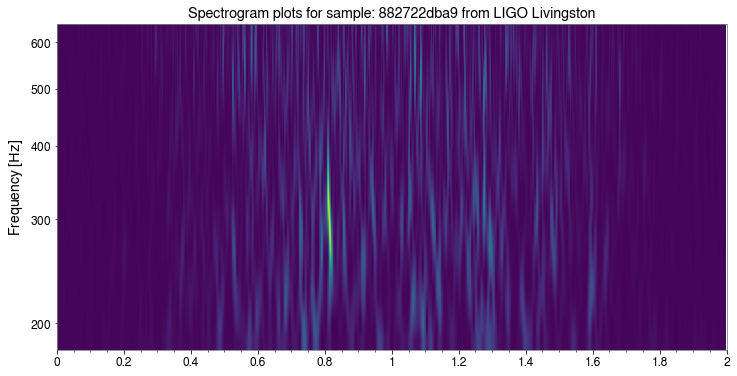

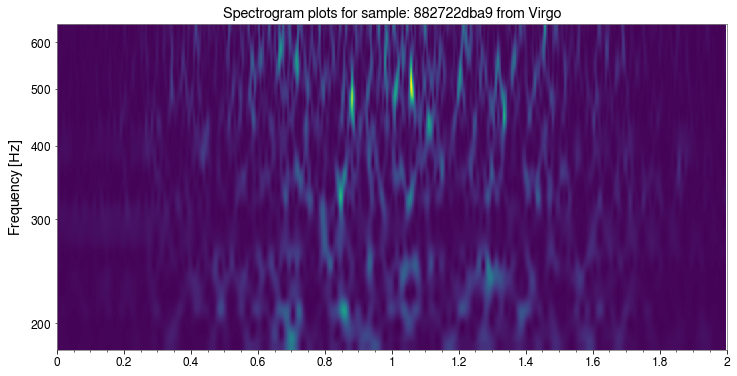

In [30]:
plot_q_transform(sample_gw_id)

In [45]:
# function to plot the Q-transform spectrogram
def plot_q_transform_sbs(sample_gw_id, sample_no_gw_id):
    # Get the data
    sample_gw = get_data(sample_gw_id)
    sample_no_gw = get_data(sample_no_gw_id)
    
    for i in range(len(obs_list)):
        # get the timeseries
        ts_gw = TimeSeries(sample_gw[i], sample_rate=sample_rate)
        ts_no_gw = TimeSeries(sample_no_gw[i], sample_rate=sample_rate)
        
        # get the Q-transform
        image_gw = ts_gw.bandpass(35, 350).q_transform()
        image_no_gw = ts_no_gw.bandpass(35, 350).q_transform()

        plt.figure(figsize=(20, 10))
        plt.subplot(131)
        plt.imshow(image_gw)
        plt.title(f"id: {sample_gw_id} | Target=1")

        plt.subplot(132)
        plt.imshow(image_no_gw)
        plt.title(f"id: {sample_no_gw_id} | Target=0")

#         plt.suptitle(f"Q-Transform Spectrogram comparison", fontsize=14)
        plt.show()
    
#     # we convert the data to gwpy's TimeSeries for analysis
#     for i in range(sample.shape[0]):
#         ax = ts.q_transform(whiten=True).plot().gca()
#         ax.set_xlabel('')
#         ax.set_title(f"ASD plots for sample: {sample_id} from {obs_list[i]}");

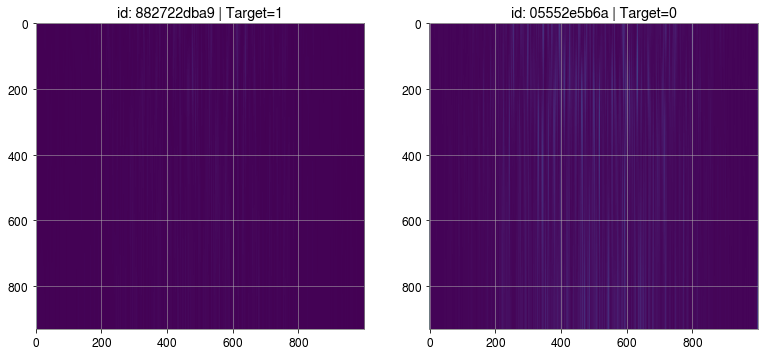

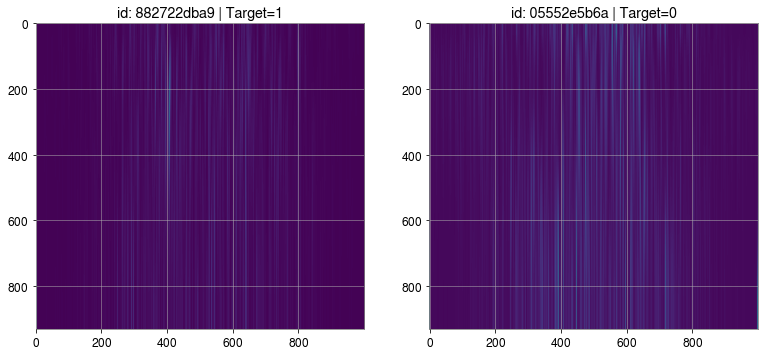

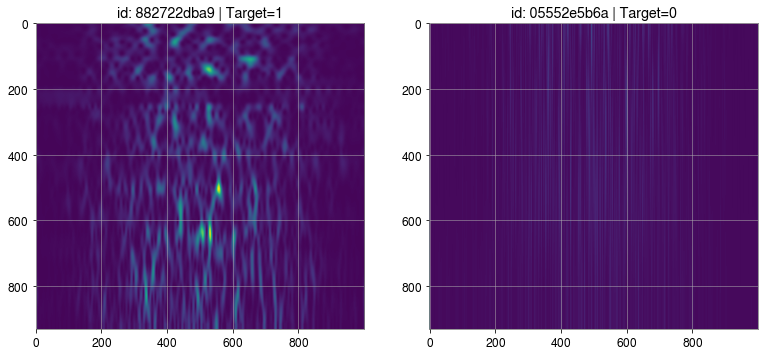

In [46]:
plot_q_transform_sbs(sample_gw_id, sample_no_gw_id)

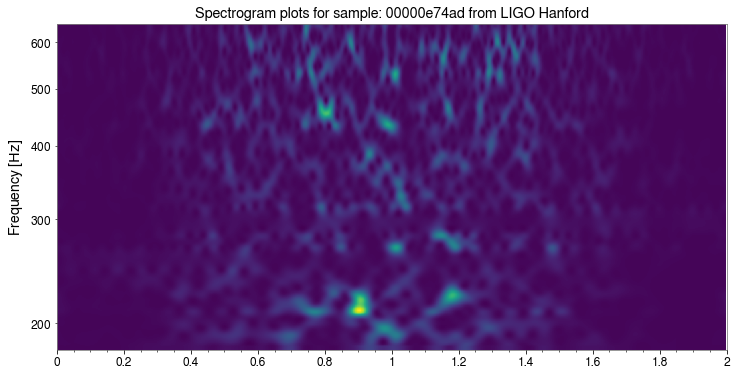

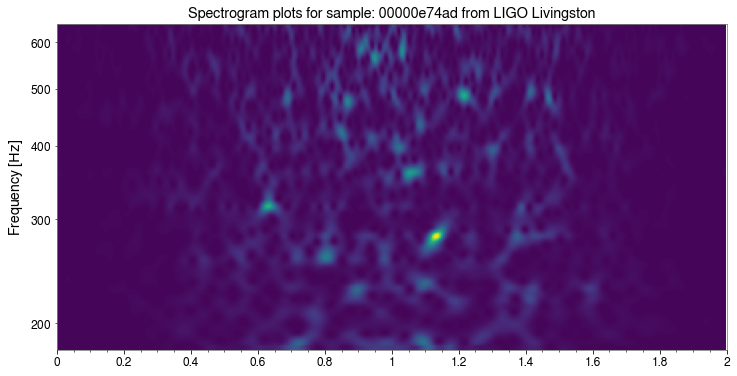

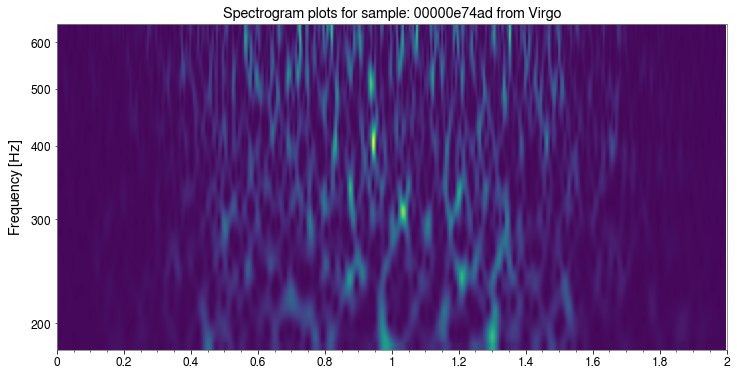

In [31]:
# let's look at the sample with obvious "chirp"
plot_q_transform(sample_id=train['id'].values[0])

404 - Not Found


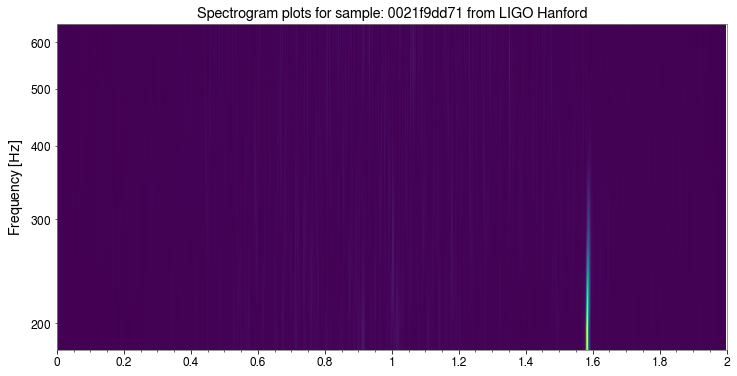

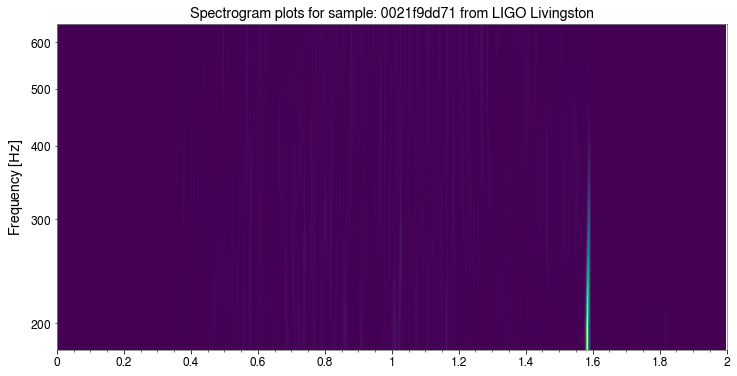

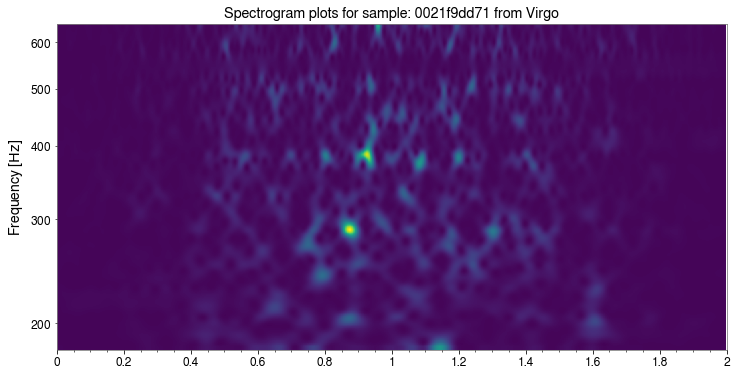

In [32]:
plot_q_transform('0021f9dd71')